In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_S_NND_S_N_cha00076_cha00076_10189_gt.png
/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_D_NNN_M_N_art00099_cha00050_11760_gt.png
/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_S_CNN_S_N_pla10127_pla10127_12137_gt.png
/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_S_NRN_S_N_ind00038_ind00038_10913_gt.png
/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_D_CRN_M_N_ani00100_ani10101_10089_gt.png
/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_D_NRN_S_N_art00010_art00014_11842_gt.png
/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S_N_cha00002_cha00002_00837_gt.png
/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_S_CRN_M_N_sec0009

In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [ ]:
from PIL import Image, ImageChops, ImageEnhance

def convert_to_ela_image(path, quality):
    # Define the filename for the temporary JPEG image
    temp_filename = 'temp_file_name.jpg'
    
    # Open the original image and ensure it is in RGB format 
    image = Image.open(path).convert('RGB')
    
    # Save the image as a JPEG at the specified quality, introducing compression artifacts
    image.save(temp_filename, 'JPEG', quality=quality)
    
    # Reopen the compressed image
    temp_image = Image.open(temp_filename)
    
    # Compute the pixel-wise difference between the original and compressed images
    # This highlights the areas of change due to compression
    ela_image = ImageChops.difference(image, temp_image)
    
    # Get the maximum difference in each color channel (R, G, B)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])  # ex[1] is the maximum value for each channel
    
    # Prevent division by zero in case there's no difference between the images
    if max_diff == 0:
        max_diff = 1
    
    # Calculate a scale factor to enhance the visibility of differences
    scale = 255.0 / max_diff
    
    # Enhance the brightness of the ELA image to make differences more visible
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    # Return the final ELA image, where bright areas may indicate potential manipulation
    return ela_image


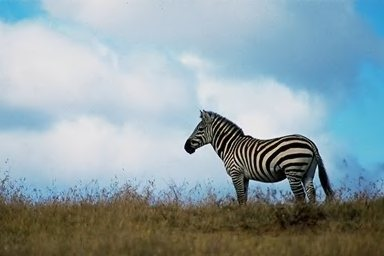

In [5]:
real_image_path = r"C:\Users\asus\.cache\kagglehub\datasets\divg07\casia-20-image-tampering-detection-dataset\versions\1\CASIA2\Au\Au_ani_00001.jpg"
Image.open(real_image_path)

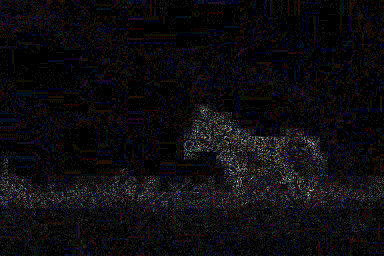

In [ ]:
convert_to_ela_image(real_image_path, 90)
#90: This is the JPEG compression quality used when re-saving the image. Lower quality (e.g., 85–90) will introduce more compression artifacts and is useful for ELA.

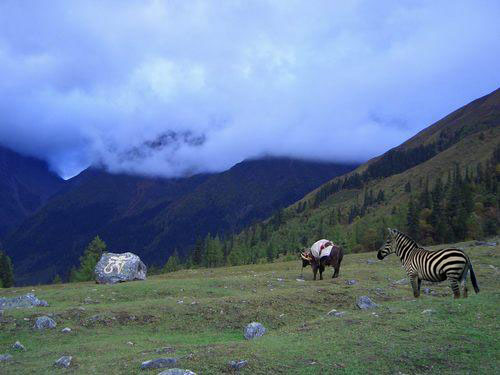

In [7]:
fake_image_path = r"C:\Users\asus\.cache\kagglehub\datasets\divg07\casia-20-image-tampering-detection-dataset\versions\1\CASIA2\Tp\Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg"
Image.open(fake_image_path)

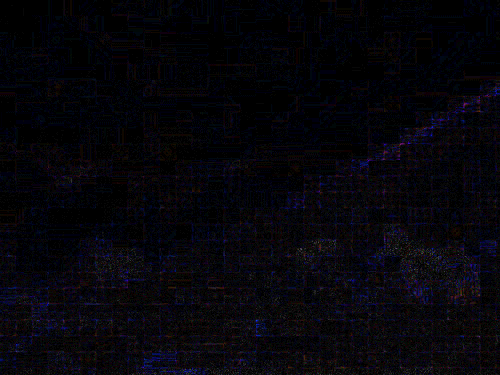

In [8]:
convert_to_ela_image(fake_image_path, 90)

In [9]:
image_size = (128, 128)

In [ ]:
def prepare_image(image_path):
    # Convert the input image to its ELA representation with JPEG quality of 90,
    # then resize it to the fixed image_size (e.g., (128, 128))
    # Convert the resized ELA image to a NumPy array
    # Flatten the 3D image array (width x height x channels) into a 1D vector
    # Normalize pixel values to the range [0, 1] by dividing by 255
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0


In [11]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [ ]:
import random

# Define the path to the 'Au' (Authentic) images from the CASIA2 dataset
path = r"C:\Users\asus\.cache\kagglehub\datasets\divg07\casia-20-image-tampering-detection-dataset\versions\1\CASIA2\Au"

# Traverse all directories and files in the given path
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        # Check if the file is an image (JPEG or PNG)
        if filename.endswith('jpg') or filename.endswith('png'):
            # Get the full path to the image
            full_path = os.path.join(dirname, filename)

            # Prepare the image using ELA and flatten it into a feature vector, then add to X
            X.append(prepare_image(full_path))

            # Append label 1 (indicating this is an authentic image) to Y
            Y.append(1)

            # Print progress every 500 images
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

# Shuffle the feature list X and the corresponding labels Y together (to randomize the dataset)
random.shuffle(X)

# Limit the dataset to the first 2100 samples for consistency or resource constraint
X = X[:2100]
Y = Y[:2100]

# Print the total number of samples in X and Y
print(len(X), len(Y))


Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [ ]:
# Define the path to the 'Tp' (Tampered) images from the CASIA2 dataset
path = r"C:\Users\asus\.cache\kagglehub\datasets\divg07\casia-20-image-tampering-detection-dataset\versions\1\CASIA2\Tp"

# Walk through all directories and files in the given path
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        # Process only JPEG or PNG images
        if filename.endswith('jpg') or filename.endswith('png'):
            # Construct the full file path
            full_path = os.path.join(dirname, filename)
            
            # Prepare the image (generate ELA, resize, flatten, normalize) and add it to X
            X.append(prepare_image(full_path))
            
            # Label the image as '0' indicating it is tampered
            Y.append(0)
            
            # Print progress every 500 images processed
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

# After processing, print the total number of samples collected in X and Y
print(len(X), len(Y))


Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [ ]:
import tensorflow as tf

# Convert the list of feature vectors (flattened ELA images) to a NumPy array
X = np.array(X)

# Convert the labels Y to one-hot encoded vectors for 2 classes (0 and 1)
# For example, label 0 becomes [1, 0], label 1 becomes [0, 1]
Y = tf.keras.utils.to_categorical(Y, 2)

# Reshape X to 4D tensor expected by CNNs:
# -1 means infer the number of samples automatically
# 128 x 128 is the target image size (height x width)
# 3 is the number of color channels (RGB)
X = X.reshape(-1, 128, 128, 3)


In [ ]:
# Split the dataset into training and validation sets
# 20% of data will be used for validation, random_state=5 ensures reproducibility
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Reshape the entire X array to shape (-1, 1, 1, 1)
# Note: This changes X after the split, but does not affect X_train or X_val
X = X.reshape(-1,1,1,1)

# Print the number of samples in training set and their labels
print(len(X_train), len(Y_train))

# Print the number of samples in validation set and their labels
print(len(X_val), len(Y_val))


3331 3331
833 833


In [ ]:
def build_model():
    model = Sequential()
    
    # First convolutional layer:
    # - 32 filters help capture various features (edges, textures, etc.) from the input images.
    # - Kernel size 5x5 captures slightly larger patterns than smaller kernels (e.g., 3x3),
    #   which can be useful for identifying tampering artifacts in ELA images.
    # - 'valid' padding means no zero-padding, so output shrinks slightly, reducing parameters.
    # - ReLU activation introduces non-linearity, helping model learn complex patterns.
    # - Input shape matches our processed image size (128x128 pixels, RGB channels).
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu', input_shape=(128, 128, 3)))
    
    # Second convolutional layer:
    # - Another 32 filters to build on the features detected by the first layer,
    #   learning more complex and abstract representations.
    # - Same kernel size and activation to keep consistency in feature extraction.
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu'))
    
    # Max Pooling layer:
    # - Reduces spatial dimensions by a factor of 2, lowering computational cost and parameters.
    # - Helps the model become spatially invariant to small shifts or distortions.
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # Dropout layer:
    # - Randomly drops 25% of neurons during training to prevent overfitting.
    # - Helps the model generalize better by avoiding reliance on specific neurons.
    model.add(Dropout(0.25))
    
    # Flatten layer:
    # - Converts the 2D feature maps into a 1D vector to feed into fully connected layers.
    # - This transition allows the model to combine learned spatial features for classification.
    model.add(Flatten())
    
    # Fully connected Dense layer:
    # - 256 neurons provide a good balance between learning capacity and computational efficiency.
    # - ReLU activation introduces non-linearity for complex decision boundaries.
    model.add(Dense(256, activation='relu'))
    
    # Dropout layer:
    # - Higher dropout rate (50%) here encourages stronger regularization in dense layers,
    #   which often have many parameters and risk overfitting.
    model.add(Dropout(0.5))
    
    # Output Dense layer:
    # - 2 neurons correspond to two classes: Authentic (1) and Tampered (0).
    # - Softmax activation outputs probabilities summing to 1 for these classes.
    model.add(Dense(2, activation='softmax'))
    
    # Return the constructed CNN model ready to be compiled and trained
    return model


In [17]:
model = build_model()
model.summary()

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

# Define training parameters:
epochs = 30         # Number of complete passes through the training dataset
batch_size = 32     # Number of samples per gradient update
init_lr = 1e-4      # Initial learning rate for the optimizer

# Create Adam optimizer with a learning rate schedule:
# - learning_rate is set to init_lr (0.0001) initially
# - decay gradually decreases the learning rate over epochs (init_lr / epochs)
# This helps the model converge more smoothly by reducing step size over time
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr, decay=init_lr / epochs)


C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Compile the model with:
# - the Adam optimizer defined earlier
# - binary crossentropy loss for two-class classification
# - accuracy as a metric to monitor training progress
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping to prevent overfitting:
# - monitor validation accuracy ('val_acc')
# - stop training if accuracy does not improve by at least min_delta (0) for 'patience' (2) epochs
# - verbose=0 means no output during stopping
# - mode='max' means it looks for maximum value (accuracy) to stop
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=2,
                               verbose=0,
                               mode='max')


In [20]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 591ms/step - accuracy: 0.6408 - loss: 0.5906 - val_accuracy: 0.8908 - val_loss: 0.3242
Epoch 2/30


C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 561ms/step - accuracy: 0.8913 - loss: 0.3302 - val_accuracy: 0.8944 - val_loss: 0.2972
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 549ms/step - accuracy: 0.8847 - loss: 0.3320 - val_accuracy: 0.8944 - val_loss: 0.2908
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 553ms/step - accuracy: 0.9028 - loss: 0.2803 - val_accuracy: 0.9076 - val_loss: 0.2593
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 559ms/step - accuracy: 0.9072 - loss: 0.2678 - val_accuracy: 0.8968 - val_loss: 0.2781
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 100s 958ms/step - accuracy: 0.9165 - loss: 0.2551 - val_accuracy: 0.9172 - val_loss: 0.2237
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9183 - loss: 0.2277 - val_accuracy: 0.9136 - val_loss: 0.2275
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 104s 993ms/step - accuracy: 0.8860 - loss: 0.2898 - val_accuracy: 0.9184 - val_loss: 0.2153
Epoch 9/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 61s 579ms/step - accuracy: 0.9232 - loss: 0.2185 - val

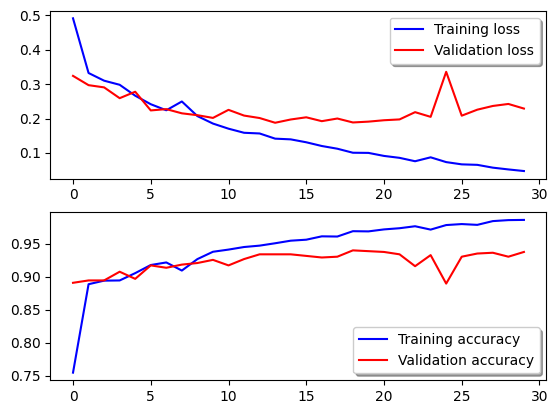

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [24]:
# Make predictions
predicted_classes = model.predict(X_val)
predicted_classes = np.argmax(predicted_classes, axis=1)

# Convert the one-hot encoded labels back to class labels
true_classes = np.argmax(Y_val, axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step


In [25]:
# Define class labels
class_labels = ['Fake', 'Real']

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


              precision    recall  f1-score   support

        Fake       0.92      0.96      0.94       407
        Real       0.96      0.92      0.94       426

    accuracy                           0.94       833
   macro avg       0.94      0.94      0.94       833
weighted avg       0.94      0.94      0.94       833



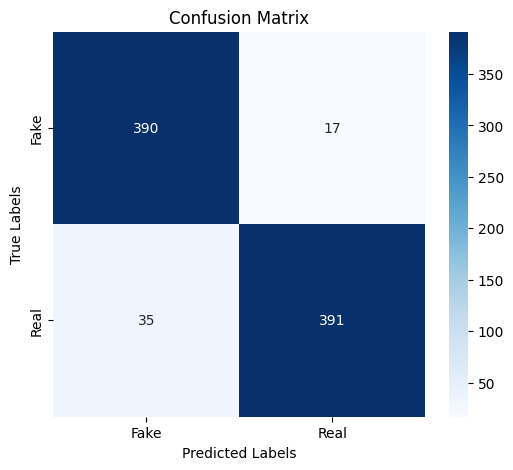

In [26]:
# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [27]:
model.save('image_forgery_detection_casia2.h5')

In [28]:
from IPython.display import FileLink
FileLink(r'image_forgery_detection_casia2.h5')

c:\Users\asus\Downloads\Image Forgery3\image_forgery_detection_casia2.h5

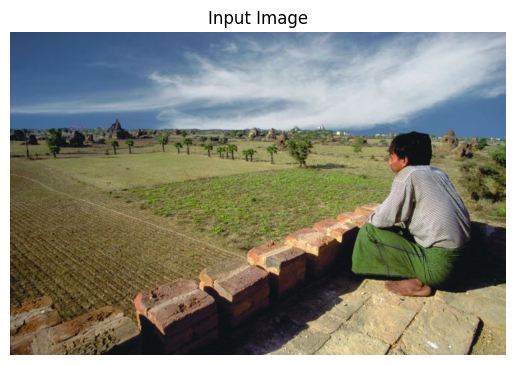

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
The input image is predicted to be: Fake with 99.65% confidence.


In [10]:
import numpy as np
from keras.models import load_model
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt

# --- Use the exact same functions as in image-forgery-detection.ipynb ---
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

# --- Load the saved model ---
model = load_model('image_forgery_detection_casia2.h5')
class_labels = ['Fake', 'Real']

# --- Path to the input image ---
input_image_path = r"C:\Users\asus\Downloads\Image_Forgery_2\casia_split\val\Tp\Tp_D_NRN_M_N_cha10123_nat10124_12192.jpg"  # Change to your test image

# Display the input image
img = Image.open(input_image_path)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()
input_image = prepare_image(input_image_path)

# --- Prepare the input image ---
input_image = prepare_image(input_image_path)
input_image = input_image.reshape(1, 128, 128, 3)  # Reshape to match the model's input shape

# --- Make a prediction ---
prediction = model.predict(input_image)

# --- Get the predicted class and confidence ---
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = prediction[0][predicted_class] * 100  # Convert to percentage

# --- Print the result ---
print(f"The input image is predicted to be: {class_labels[predicted_class]} with {confidence:.2f}% confidence.")